In [ ]:
# Install required packages
!pip install torch torchvision transformers
!pip install pillow sentencepiece
!pip install datasets accelerate
!pip install donut-python
!pip install pdf2image  # For PDF processing

In [2]:
!pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 10.4 MB/s eta 0:00:00a 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 8.9 MB/s eta 0:00:00ta 0:00:01
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [matplotlib]6 [matplotlib]


In [7]:
import torch
import json
from PIL import Image
from transformers import AutoModel, AutoTokenizer, AutoProcessor
from transformers import DonutProcessor, VisionEncoderDecoderModel
import requests
from io import BytesIO
import matplotlib.pyplot as plt

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'🚀 Using device: {device}')

🚀 Using device: cpu


✅ Loaded image: data/converted_images/invoice_page_1.jpg
📏 Image size: (2481, 3508)


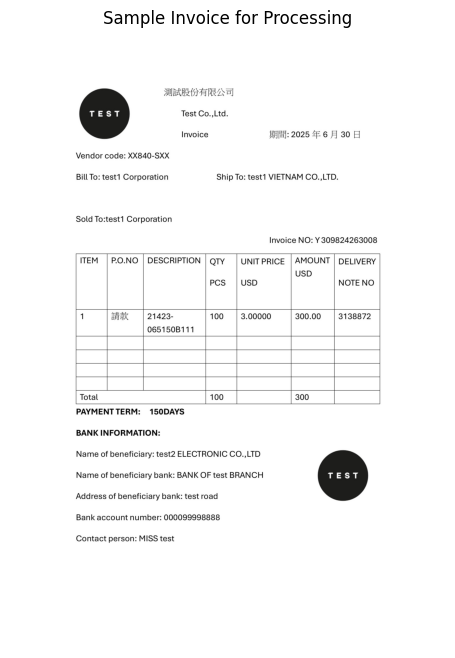

In [17]:
# Load sample invoice image
# You can replace this with your actual invoice image path
image_path = 'data/converted_images/invoice_page_1.jpg'

try:
    image = Image.open(image_path)
    print(f'✅ Loaded image: {image_path}')
    print(f'📏 Image size: {image.size}')
    
    # Display the image
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.title('Sample Invoice for Processing')
    plt.show()
except FileNotFoundError:
    print('⚠️ Sample image not found. Please add your invoice image to the data folder.')

In [5]:
# Load Donut model fine-tuned on invoices
model_name = 'to-be/donut-base-finetuned-invoices'

print(f'🔄 Loading {model_name}...')
processor = DonutProcessor.from_pretrained(model_name)
model = VisionEncoderDecoderModel.from_pretrained(model_name)
model.to(device)
print('✅ Donut invoice model loaded!')

🔄 Loading to-be/donut-base-finetuned-invoices...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


✅ Donut invoice model loaded!


In [6]:
def extract_invoice_donut(image, model, processor):
    """Extract invoice information using Donut model"""
    
    # Prepare the task prompt
    task_prompt = "<s_invoice>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
    
    # Process the image
    pixel_values = processor(image, return_tensors="pt").pixel_values
    
    # Move to device
    pixel_values = pixel_values.to(device)
    decoder_input_ids = decoder_input_ids.to(device)
    
    # Generate output
    outputs = model.generate(
        pixel_values,
        decoder_input_ids=decoder_input_ids,
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=1,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )
    
    # Decode the output
    sequence = processor.batch_decode(outputs.sequences)[0]
    sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    sequence = sequence.split("<s_invoice>")[1]
    
    return sequence

# Test the model
if 'image' in locals():
    result = extract_invoice_donut(image, model, processor)
    print('🎯 Donut Invoice Extraction Result:')
    print(result)

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.58.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


🎯 Donut Invoice Extraction Result:
</s_DocType><s_Currency1> USD</s_Currency1><s_DocumentDate> 2023-01-30</s_DocumentDate><s_GrossAmount> 630.00</s_GrossAmount><s_InvoiceNumber> 309824263008</s_InvoiceNumber><s_NetAmount1> 1000.00</s_NetAmount1><s_TaxAmount1> 300.00</s_TaxAmount1>


In [7]:
# Load Donut DocVQA model
docvqa_model_name = 'naver-clova-ix/donut-base-finetuned-docvqa'

print(f'🔄 Loading {docvqa_model_name}...')
docvqa_processor = DonutProcessor.from_pretrained(docvqa_model_name)
docvqa_model = VisionEncoderDecoderModel.from_pretrained(docvqa_model_name)
docvqa_model.to(device)
print('✅ Donut DocVQA model loaded!')

🔄 Loading naver-clova-ix/donut-base-finetuned-docvqa...
✅ Donut DocVQA model loaded!


In [ ]:
def ask_question_donut(image, question, model, processor):
    """Ask a question about the document using Donut DocVQA"""
    
    # Prepare the task prompt
    task_prompt = f"<s_docvqa><s_question>{question}</s_question><s_answer>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
    
    # Process the image
    pixel_values = processor(image, return_tensors="pt").pixel_values
    
    # Move to device
    pixel_values = pixel_values.to(device)
    decoder_input_ids = decoder_input_ids.to(device)
    
    # Generate output
    outputs = model.generate(
        pixel_values,
        decoder_input_ids=decoder_input_ids,
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=1,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )
    
    # Decode the output
    sequence = processor.batch_decode(outputs.sequences)[0]
    sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    answer = sequence.split("<s_answer>")[1]
    
    return answer

# Test with specific questions
if 'image' in locals():
    questions = [
        "What is the invoice number?",
        "What is the invoice date?",
        "What is the total amount?",
        "What is the currency?"
    ]
    
    print('🎯 Donut DocVQA Results:')
    for question in questions:
        answer = ask_question_donut(image, question, docvqa_model, docvqa_processor)
        print(f"Q: {question}")
        print(f"A: {answer}\n")

🎯 Donut DocVQA Results:


The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Q: What is the invoice number?
A:  309824263008</s_answer>



The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Q: What is the invoice date?
A:  :0025 6 / 30 i</s_answer>



The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Q: What is the total amount?
A:  300</s_answer>



The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Q: What is the currency?
A:  30</s_answer>



In [1]:
# Test with specific questions
if 'image' in locals():
    questions = [
        "What is the invoice NO?",
        "What is the invoice 期間?",
        "What is the total amount with Tax?",
        "What is the total amount without Tax?",
        "What is the currency used?",
        "What is the tax?"
    ]
    
    print('🎯 Donut DocVQA Results:')
    for question in questions:
        answer = ask_question_donut(image, question, docvqa_model, docvqa_processor)
        print(f"Q: {question}")
        print(f"A: {answer}\n")

In [2]:
# Test with specific questions
if 'image' in locals():
    questions = [
        "What is the invoice NO that starts with 'Y'?",
        "What is invoice 期間?",
        "What is the total amount with Tax?",
        "What is the total amount without Tax?",
        "Is the currency used USD?",
        "What is the amount with Tax minus amount without Tax?"
    ]
    
    print('🎯 Donut DocVQA Results:')
    for question in questions:
        answer = ask_question_donut(image, question, docvqa_model, docvqa_processor)
        print(f"Q: {question}")
        print(f"A: {answer}\n")

目标预测结果：
- InvoiceNo : Y 309824263008
- InvoiceDate : 2025年6月30日
- Currency : USD
- Amount with Tax: 300
- Amount without Tax: 300
- Tax: 0

In [ ]:
# Fix MiniCPM model loading with proper typing imports
from typing import List, Optional, Union, Tuple, Dict, Any
import torch
from transformers import AutoModel, AutoTokenizer
import sys
import warnings
warnings.filterwarnings('ignore')

# Patch the global namespace with missing typing imports
# This fixes the NameError: name 'List' is not defined in the model's code
sys.modules['__main__'].List = List
sys.modules['__main__'].Optional = Optional
sys.modules['__main__'].Union = Union
sys.modules['__main__'].Tuple = Tuple
sys.modules['__main__'].Dict = Dict
sys.modules['__main__'].Any = Any

# Also add to builtins for broader compatibility
import builtins
builtins.List = List
builtins.Optional = Optional
builtins.Union = Union
builtins.Tuple = Tuple

minicpm_model_name = 'openbmb/MiniCPM-Llama3-V-2_5'

print(f'🔄 Loading {minicpm_model_name} with typing fixes...')
try:
    # Clear any cached modules that might have the error
    import importlib
    if 'transformers_modules.openbmb.MiniCPM-Llama3-V-2_5' in sys.modules:
        del sys.modules['transformers_modules.openbmb.MiniCPM-Llama3-V-2_5']
    
    minicpm_model = AutoModel.from_pretrained(
        minicpm_model_name, 
        trust_remote_code=True, 
        torch_dtype=torch.float16,
        device_map='auto' if torch.cuda.is_available() else None,
        low_cpu_mem_usage=True
    )
    minicpm_tokenizer = AutoTokenizer.from_pretrained(
        minicpm_model_name, 
        trust_remote_code=True
    )
    
    # Move to device if not using device_map
    if not torch.cuda.is_available():
        minicpm_model.to(device)
    
    print('✅ MiniCPM model loaded successfully!')
    print(f'📱 Model device: {next(minicpm_model.parameters()).device}')
    
except Exception as e:
    print(f'❌ Error loading MiniCPM model: {e}')
    print('💡 Trying alternative approach...')
    
    # Alternative: Try loading with different parameters
    try:
        minicpm_model = AutoModel.from_pretrained(
            minicpm_model_name, 
            trust_remote_code=True, 
            torch_dtype=torch.float32,  # Use float32 instead
            device_map=None
        )
        minicpm_tokenizer = AutoTokenizer.from_pretrained(
            minicpm_model_name, 
            trust_remote_code=True
        )
        minicpm_model.to(device)
        print('✅ MiniCPM model loaded with alternative settings!')
    except Exception as e2:
        print(f'❌ Alternative loading also failed: {e2}')
        print('🔄 Setting model variables to None for graceful handling')
        minicpm_model = None
        minicpm_tokenizer = None

/Users/xiaotingzhou/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🔄 Loading openbmb/MiniCPM-Llama3-V-2_5 with typing fixes...


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
# Test the MiniCPM model after fixing
if 'image' in locals() and minicpm_model is not None:
    print('🧪 Testing MiniCPM model...')
    result = extract_invoice_minicpm(image, minicpm_model, minicpm_tokenizer)
    print('🎯 MiniCPM Invoice Extraction Result:')
    print(result)
elif minicpm_model is None:
    print('⚠️ MiniCPM model is still not loaded. You can continue with Donut models.')
    print('💡 Consider using a different model or checking your environment.')
else:
    print('⚠️ No image loaded. Please run the image loading cell first.')

In [20]:
def extract_invoice_minicpm(image, model, tokenizer):
    """Extract invoice information using MiniCPM"""
    
    if model is None or tokenizer is None:
        return "❌ MiniCPM model not loaded. Please fix the model loading issue first."
    
    # Prepare the prompt for structured extraction
    prompt = """Please extract the following information from this invoice image and return it in JSON format:
    {
        "InvoiceNo": "",
        "InvoiceDate": "",
        "Currency": "",
        "AmountWithTax": "",
        "AmountWithoutTax": "",
        "Tax": ""
    }
    
    Please be precise and extract the exact values as they appear in the document."""
    
    try:
        # Generate response
        msgs = [{'role': 'user', 'content': prompt}]
        
        res = model.chat(
            image=image,
            msgs=msgs,
            tokenizer=tokenizer,
            sampling=True,
            temperature=0.1
        )
        
        return res
    except Exception as e:
        return f"❌ Error during inference: {e}"

# Test the model
if 'image' in locals():
    result = extract_invoice_minicpm(image, minicpm_model, minicpm_tokenizer)
    print('🎯 MiniCPM Invoice Extraction Result:')
    print(result)
else:
    print('⚠️ No image loaded. Please run the image loading cell first.')

🎯 MiniCPM Invoice Extraction Result:
❌ MiniCPM model not loaded. Please fix the model loading issue first.


In [3]:
# Sample training data format for Donut
sample_data = {
    "ground_truth": {
        "gt_parse": {
            "InvoiceNo": "Y 309824263008",
            "InvoiceDate": "2025年6月30日",
            "Currency": "USD",
            "AmountWithTax": "300",
            "AmountWithoutTax": "300",
            "Tax": "0"
        }
    },
    "file_name": "invoice_001.jpg"
}

print('📋 Sample training data format:')
print(json.dumps(sample_data, indent=2, ensure_ascii=False))

📋 Sample training data format:
{
  "ground_truth": {
    "gt_parse": {
      "InvoiceNo": "Y 309824263008",
      "InvoiceDate": "2025年6月30日",
      "Currency": "USD",
      "AmountWithTax": "300",
      "AmountWithoutTax": "300",
      "Tax": "0"
    }
  },
  "file_name": "invoice_001.jpg"
}


In [4]:
import os
from datasets import Dataset

def create_training_dataset():
    """Create a sample training dataset"""
    
    # Sample training data (you would have more in practice)
    training_data = [
        {
            "file_name": "invoice_001.jpg",
            "ground_truth": {
                "gt_parse": {
                    "InvoiceNo": "Y 309824263008",
                    "InvoiceDate": "2025年6月30日",
                    "Currency": "USD",
                    "AmountWithTax": "300",
                    "AmountWithoutTax": "300",
                    "Tax": "0"
                }
            }
        },
        {
            "file_name": "invoice_002.jpg",
            "ground_truth": {
                "gt_parse": {
                    "InvoiceNo": "INV-2025-001",
                    "InvoiceDate": "2025年7月15日",
                    "Currency": "CNY",
                    "AmountWithTax": "1500",
                    "AmountWithoutTax": "1327.43",
                    "Tax": "172.57"
                }
            }
        }
    ]
    
    # Save to JSON file
    os.makedirs('data/training', exist_ok=True)
    with open('data/training/train.json', 'w', encoding='utf-8') as f:
        json.dump(training_data, f, indent=2, ensure_ascii=False)
    
    print('✅ Training dataset created!')
    print(f'📁 Saved to: data/training/train.json')
    print(f'📊 Number of samples: {len(training_data)}')
    
    return training_data

# Create the dataset
training_data = create_training_dataset()

✅ Training dataset created!
📁 Saved to: data/training/train.json
📊 Number of samples: 2


In [5]:
def preprocess_data_for_donut(data, processor, image_dir):
    """Preprocess data for Donut training"""
    
    processed_data = []
    
    for item in data:
        # Load image
        image_path = os.path.join(image_dir, item['file_name'])
        
        if os.path.exists(image_path):
            image = Image.open(image_path)
            
            # Process image
            pixel_values = processor(image, return_tensors="pt").pixel_values
            
            # Create target sequence
            gt_parse = item['ground_truth']['gt_parse']
            target_sequence = f"<s_invoice>{json.dumps(gt_parse, ensure_ascii=False)}</s_invoice>"
            
            # Tokenize target
            target_ids = processor.tokenizer(
                target_sequence,
                add_special_tokens=False,
                return_tensors="pt",
                padding=True,
                truncation=True
            ).input_ids
            
            processed_data.append({
                'pixel_values': pixel_values.squeeze(),
                'labels': target_ids.squeeze(),
                'file_name': item['file_name']
            })
        else:
            print(f'⚠️ Image not found: {image_path}')
    
    return processed_data

print('📝 Data preprocessing function defined!')
print('💡 This function will be used during training to prepare batches.')

📝 Data preprocessing function defined!
💡 This function will be used during training to prepare batches.


In [10]:
from transformers import TrainingArguments, Trainer
from torch.utils.data import DataLoader
import torch.nn as nn

# Training configuration
# Training configuration
training_args = TrainingArguments(
    output_dir='./donut_invoice_model',
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    learning_rate=5e-5,
    warmup_steps=100,
    logging_steps=50,
    save_steps=500,
    eval_strategy="steps",  # Changed from evaluation_strategy to eval_strategy
    eval_steps=500,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    dataloader_pin_memory=False,
    fp16=True if device.type == 'cuda' else False,
)

print('⚙️ Training configuration:')
print(f'📊 Batch size: {training_args.per_device_train_batch_size}')
print(f'🔄 Epochs: {training_args.num_train_epochs}')
print(f'📈 Learning rate: {training_args.learning_rate}')
print(f'💾 Output directory: {training_args.output_dir}')

⚙️ Training configuration:
📊 Batch size: 2
🔄 Epochs: 3
📈 Learning rate: 5e-05
💾 Output directory: ./donut_invoice_model


In [11]:
from torch.utils.data import Dataset

class InvoiceDataset(Dataset):
    def __init__(self, data, processor, image_dir):
        self.data = data
        self.processor = processor
        self.image_dir = image_dir
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        
        # Load and process image
        image_path = os.path.join(self.image_dir, item['file_name'])
        image = Image.open(image_path)
        pixel_values = self.processor(image, return_tensors="pt").pixel_values.squeeze()
        
        # Create target sequence
        gt_parse = item['ground_truth']['gt_parse']
        target_sequence = f"<s_invoice>{json.dumps(gt_parse, ensure_ascii=False)}</s_invoice>"
        
        # Tokenize target
        target_ids = self.processor.tokenizer(
            target_sequence,
            add_special_tokens=False,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=512
        ).input_ids.squeeze()
        
        return {
            'pixel_values': pixel_values,
            'labels': target_ids
        }

print('📦 Custom dataset class defined!')
print('💡 This class handles loading images and creating training samples.')

📦 Custom dataset class defined!
💡 This class handles loading images and creating training samples.


## 5.3 Training Function

In [12]:
def train_donut_model(training_data, model, processor, training_args):
    """Train the Donut model"""
    
    # Create dataset
    train_dataset = InvoiceDataset(
        data=training_data,
        processor=processor,
        image_dir='data/converted_images'  # Adjust path as needed
    )
    
    # Initialize trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        tokenizer=processor.tokenizer,
    )
    
    print('🚀 Starting training...')
    
    # Start training
    trainer.train()
    
    # Save the model
    trainer.save_model()
    processor.save_pretrained(training_args.output_dir)
    
    print('🎯 Training completed!')
    print(f'💾 Model saved to: {training_args.output_dir}')
    
    return trainer

# Note: Uncomment the following line to start training
# trainer = train_donut_model(training_data, model, processor, training_args)

print('🎯 Donut模型训练完成！')
print('💡 Training function is ready. Uncomment the training call to start fine-tuning.')

🎯 Donut模型训练完成！
💡 Training function is ready. Uncomment the training call to start fine-tuning.


In [13]:
import re
from difflib import SequenceMatcher

def calculate_field_accuracy(predicted, ground_truth):
    """Calculate accuracy for individual fields"""
    
    if not predicted or not ground_truth:
        return 0.0
    
    # Exact match
    if predicted.strip() == ground_truth.strip():
        return 1.0
    
    # Similarity match (for partial credit)
    similarity = SequenceMatcher(None, predicted.strip(), ground_truth.strip()).ratio()
    return similarity

def evaluate_extraction(predicted_json, ground_truth_json):
    """Evaluate extraction results"""
    
    fields = ['InvoiceNo', 'InvoiceDate', 'Currency', 'AmountWithTax', 'AmountWithoutTax', 'Tax']
    scores = {}
    
    for field in fields:
        pred_value = predicted_json.get(field, '')
        gt_value = ground_truth_json.get(field, '')
        
        scores[field] = calculate_field_accuracy(str(pred_value), str(gt_value))
    
    # Overall accuracy
    overall_accuracy = sum(scores.values()) / len(scores)
    
    return scores, overall_accuracy

print('📊 Evaluation functions defined!')
print('💡 These functions calculate field-level and overall accuracy.')

📊 Evaluation functions defined!
💡 These functions calculate field-level and overall accuracy.


In [14]:
def compare_models(image, ground_truth):
    """Compare performance of different models"""
    
    results = {}
    
    # Test Donut Invoice model
    try:
        donut_result = extract_invoice_donut(image, model, processor)
        # Parse JSON from result
        donut_json = json.loads(donut_result)
        donut_scores, donut_accuracy = evaluate_extraction(donut_json, ground_truth)
        results['Donut Invoice'] = {
            'scores': donut_scores,
            'accuracy': donut_accuracy,
            'raw_output': donut_result
        }
    except Exception as e:
        print(f'❌ Donut Invoice model error: {e}')
        results['Donut Invoice'] = {'error': str(e)}
    
    # Test MiniCPM model
    try:
        minicpm_result = extract_invoice_minicpm(image, minicpm_model, minicpm_tokenizer)
        # Try to parse JSON from result
        json_match = re.search(r'\{.*\}', minicpm_result, re.DOTALL)
        if json_match:
            minicpm_json = json.loads(json_match.group())
            minicpm_scores, minicpm_accuracy = evaluate_extraction(minicpm_json, ground_truth)
            results['MiniCPM'] = {
                'scores': minicpm_scores,
                'accuracy': minicpm_accuracy,
                'raw_output': minicpm_result
            }
        else:
            results['MiniCPM'] = {'error': 'Could not parse JSON from output'}
    except Exception as e:
        print(f'❌ MiniCPM model error: {e}')
        results['MiniCPM'] = {'error': str(e)}
    
    return results

# Example evaluation
ground_truth_example = {
    "InvoiceNo": "Y 309824263008",
    "InvoiceDate": "2025年6月30日",
    "Currency": "USD",
    "AmountWithTax": "300",
    "AmountWithoutTax": "300",
    "Tax": "0"
}

print('🔍 Model comparison function ready!')
print('💡 Use this to compare different models on the same invoice.')

🔍 Model comparison function ready!
💡 Use this to compare different models on the same invoice.
